##IMPORTS

In [ ]:
import numpy as np
from pathlib import Path
import nltk
import re
from tqdm import tqdm
from nltk.corpus import stopwords
import pandas as pd
import stopwordsiso as stopwords
import snowballstemmer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt1
from snowballstemmer import stemmer

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from datetime import datetime

from openpyxl import load_workbook
from openpyxl.utils.exceptions import InvalidFileException

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier



print('Downlowing stopwords...')
nltk.download('stopwords')
nltk.download('punkt')

Downlowing stopwords...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##Cargamos el dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ruta del fichero .tsv
df_exist_2021 = pd.read_csv("/content/drive/Shareddrives/TFG MIREIA/CÓDIGO/EXIST2021_training.tsv", delimiter='\t')
df_exist_2021.set_index('id', inplace=True)

df_exist_2021_test = pd.read_csv("/content/drive/Shareddrives/TFG MIREIA/CÓDIGO/EXIST2021_test_labeled.tsv", delimiter='\t')
df_exist_2021_test.set_index('id', inplace=True)

#fichero datos en turco (Dataset_Sexism_Turkish.csv)
df_exist_turkish_import = pd.read_csv("/content/drive/Shareddrives/TFG MIREIA/CÓDIGO/Dataset_Sexism_Turkish.csv", delimiter=';')


df_exist_turkish_import.head()

,ID,Text,Annotation_L1_TR,Annotation_L1_Eng,Annotation_L2_TR,Annotation_L2_Eng
0,1,Aile kavrami bitiyor omur boyu nafaka evlilikl...,CINSIYETCI,SEXIST,KALIP DUSUNCE / IDEOLOJIK YAKLAŞIM veya BASKINLIK,STEREOTYPING
1,2,@deepwebtiktok2 Bu eleman mazemeyi aldirdigind...,HICBIRI-CINSIYETCI DEGIL,NOT-SEXIST,HICBIRI - Cinsiyetci Degil,NOT-SEXIST
2,3,Bu arada erkek dusmani degilim kocam da erkek?...,CINSIYETCI,SEXIST,KALIP DUSUNCE / IDEOLOJIK YAKLAŞIM veya BASKINLIK,STEREOTYPING
3,4,@yourwierdgirl bu nasil bir genelleme erkek du...,CINSIYETCI,SEXIST,FEMINIZM KARSITLIGI,ANTI-FEMINISM
4,5,erkek dusmani kiz tayfa salak midir amk en sin...,CINSIYETCI,SEXIST,KADIN DÜŞMANLIĞI veya CINSEL ICERIKLI OLMAYAN ...,MISOGYNY


In [ ]:
# Ruta al archivo JSON
exist_2024 = "/content/drive/Shareddrives/TFG MIREIA/CÓDIGO/EXIST2024_training.json"
df_exist_2024 = pd.read_json(exist_2024, orient='index')
df_exist_2024.set_index('id_EXIST', inplace=True)
df_exist_2024.head()


,lang,text,meme,path_memes,number_annotators,annotators,gender_annotators,age_annotators,ethnicities_annotators,study_levels_annotators,countries_annotators,labels_task4,labels_task5,labels_task6,split
id_EXIST,,,,,,,,,,,,,,,
110001,es,2+2=5 MITO Albert Einstein tenía bajo rendimie...,110001.jpeg,memes/110001.jpeg,6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 18-22, 23-45]","[Hispano or Latino, Hispano or Latino, Hispano...","[High school degree or equivalent, Master’s de...","[Mexico, Spain, Argentina, Spain, Mexico, Mexico]","[YES, YES, YES, YES, YES, YES]","[DIRECT, DIRECT, DIRECT, DIRECT, DIRECT, DIRECT]","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",TRAIN-MEME_ES
110002,es,CUANDO UNA MUJER VA A LUCHAR POR SUS DERECHOS,110002.jpeg,memes/110002.jpeg,6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 18-22, 23-45]","[Hispano or Latino, Hispano or Latino, Hispano...","[High school degree or equivalent, Master’s de...","[Mexico, Spain, Argentina, Spain, Mexico, Mexico]","[YES, YES, YES, YES, YES, YES]","[DIRECT, DIRECT, DIRECT, DIRECT, DIRECT, JUDGE...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",TRAIN-MEME_ES
110003,es,ІЯ ЕГЕЯ Е MOA ¿El Partido Republicano busca pe...,110003.jpeg,memes/110003.jpeg,6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 18-22, 23-45]","[Hispano or Latino, Hispano or Latino, Hispano...","[High school degree or equivalent, Master’s de...","[Mexico, Spain, Argentina, Spain, Mexico, Mexico]","[YES, YES, NO, NO, NO, NO]","[DIRECT, DIRECT, -, -, -, -]","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION, MIS...",TRAIN-MEME_ES
110004,es,"Paises que ""apoyan"" los derechos de la mujer A...",110004.jpeg,memes/110004.jpeg,6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 18-22, 23-45]","[Hispano or Latino, Hispano or Latino, Hispano...","[High school degree or equivalent, Master’s de...","[Mexico, Spain, Argentina, Spain, Mexico, Mexico]","[YES, YES, NO, NO, YES, NO]","[JUDGEMENTAL, JUDGEMENTAL, -, -, JUDGEMENTAL, -]","[[IDEOLOGICAL-INEQUALITY], [IDEOLOGICAL-INEQUA...",TRAIN-MEME_ES
110005,es,Ya verás como este 8 de marzo hay uno que te s...,110005.jpeg,memes/110005.jpeg,6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 18-22, 23-45]","[Hispano or Latino, Hispano or Latino, Hispano...","[High school degree or equivalent, Master’s de...","[Mexico, Spain, Argentina, Spain, Mexico, Mexico]","[NO, YES, NO, NO, YES, NO]","[-, JUDGEMENTAL, -, -, DIRECT, -]","[[-], [IDEOLOGICAL-INEQUALITY], [-], [-], [IDE...",TRAIN-MEME_ES


In [ ]:
df_exist_2021 = df_exist_2021.drop(['test_case', 'source'], axis=1)
df_exist_2021.head()

,language,text,task1,task2
id,,,,
1,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
2,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
3,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
4,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
5,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


In [ ]:
df_exist_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6977 entries, 1 to 6977
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  6977 non-null   object
 1   text      6977 non-null   object
 2   task1     6977 non-null   object
 3   task2     6977 non-null   object
dtypes: object(4)
memory usage: 272.5+ KB


In [ ]:
df_exist_turkish_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6915 entries, 0 to 6914
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 6915 non-null   int64 
 1   Text               6914 non-null   object
 2   Annotation_L1_TR   6915 non-null   object
 3   Annotation_L1_Eng  6915 non-null   object
 4   Annotation_L2_TR   6915 non-null   object
 5   Annotation_L2_Eng  6915 non-null   object
dtypes: int64(1), object(5)
memory usage: 324.3+ KB


Modificamos el dataset en turco para que coincida con el dataset utilizado del EXIST 2021. Modificaciones realizadas:
- Cambio del nombre de las variables de clasificación
- Cambiamos la palabra not por non
- Ponemos todo ambas clasificaciones en minúscula
- Añadimos una columna con la sigla del idioma (tr)

In [ ]:
df_exist_turkish = df_exist_turkish_import.rename(columns={'Annotation_L1_Eng': 'task1_en', 'Annotation_L2_Eng': 'task2_en', 'Annotation_L1_TR': 'task1_tr', 'Annotation_L2_TR': 'task2_tr', 'Text':'text'})

df_exist_turkish = df_exist_turkish.applymap(lambda x: x.lower() if isinstance(x, str) else x)
#añadimos la columna con el idioma
df_exist_turkish['language'] = 'tr'
#cambiamos los nombres para homogenizar el dataset final
df_exist_turkish = df_exist_turkish.replace('not-sexist', 'non-sexist')
df_exist_turkish = df_exist_turkish.replace('anti-feminism', 'ideological-inequality')
df_exist_turkish = df_exist_turkish.replace('misogyny','misogyny-non-sexual-violence')
df_exist_turkish = df_exist_turkish.replace('sexual_violence', 'sexual-violence')
df_exist_turkish = df_exist_turkish.replace('stereotyping', 'stereotyping-dominance')


df_exist_turkish = df_exist_turkish.drop(['task1_tr', 'task2_tr', 'ID'], axis=1)

df_exist_turkish.head()

,text,task1_en,task2_en,language
0,aile kavrami bitiyor omur boyu nafaka evlilikl...,sexist,stereotyping-dominance,tr
1,@deepwebtiktok2 bu eleman mazemeyi aldirdigind...,non-sexist,non-sexist,tr
2,bu arada erkek dusmani degilim kocam da erkek?...,sexist,stereotyping-dominance,tr
3,@yourwierdgirl bu nasil bir genelleme erkek du...,sexist,ideological-inequality,tr
4,erkek dusmani kiz tayfa salak midir amk en sin...,sexist,misogyny-non-sexual-violence,tr


Vemos la distribución de las variables

DATASET EXIST 2021
        label  count  percentage
0  non-sexist   3600   51.598108
1      sexist   3377   48.401892


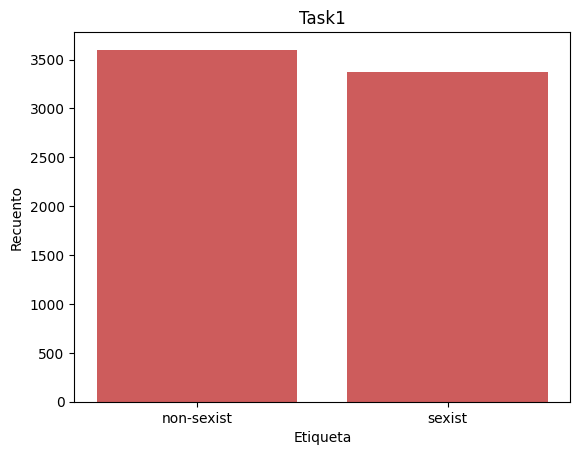

DATASET TURCO
        label  count  percentage
0  non-sexist   3166   45.791148
1      sexist   3748   54.208852


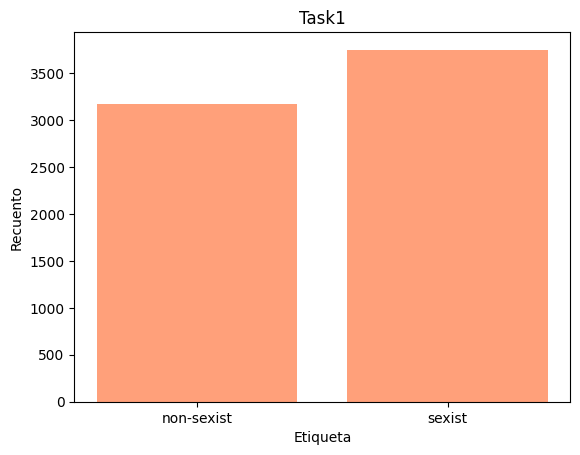

In [ ]:

if 'task1' in df_exist_2021.columns:
    df_task1=df_exist_2021[['text','task1']].groupby('task1').count().reset_index()
    df_task1.columns=['label','count']
    df_task1['percentage']=(df_task1['count']/df_task1['count'].sum())*100
    print('DATASET EXIST 2021')
    print(df_task1)


    # Crear el gráfico de barras
    plt.bar(df_task1['label'], df_task1['count'], color='indianred')
    plt.xlabel('Etiqueta')
    plt.ylabel('Recuento')
    plt.title('Task1')
    plt.show()

else:
    print("La columna no está en el DataFrame.")



if 'task1' in df_exist_turkish.columns:
    df_task1=df_exist_turkish[['text','task1']].groupby('task1').count().reset_index()
    df_task1.columns=['label','count']
    df_task1['percentage']=(df_task1['count']/df_task1['count'].sum())*100
    print('DATASET TURCO')
    print(df_task1)


    # Crear el gráfico de barras
    plt.bar(df_task1['label'], df_task1['count'], color='lightsalmon')
    plt.xlabel('Etiqueta')
    plt.ylabel('Recuento')
    plt.title('Task1')
    plt.show()

else:
    print("La columna no está en el DataFrame.")

DATASET EXIST 2021
                          label  count  percentage
0        ideological-inequality    866   12.412212
1  misogyny-non-sexual-violence    685    9.817973
2                    non-sexist   3600   51.598108
3               objectification    500    7.166404
4               sexual-violence    517    7.410062
5        stereotyping-dominance    809   11.595242


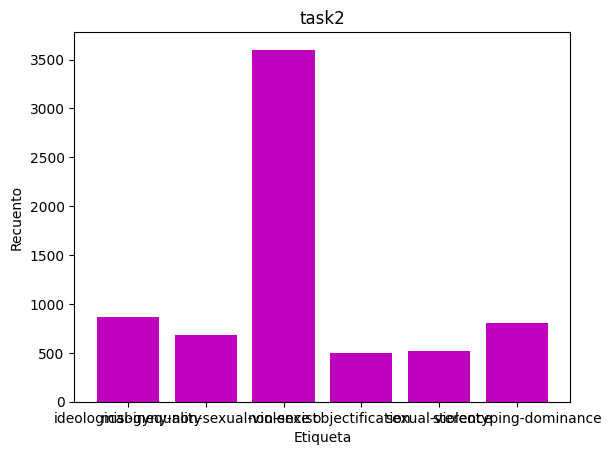

DATASET TURCO
                          label  count  percentage
0        ideological-inequality    149    2.155048
1  misogyny-non-sexual-violence    655    9.473532
2                    non-sexist   3166   45.791148
3               objectification    468    6.768875
4               sexual-violence   1352   19.554527
5        stereotyping-dominance   1124   16.256870


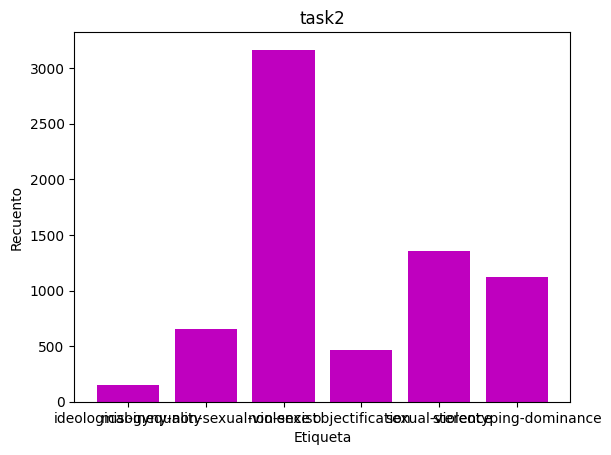

In [ ]:

if 'task2' in df_exist_2021.columns:
    df_task2=df_exist_2021[['text','task2']].groupby('task2').count().reset_index()
    df_task2.columns=['label','count']
    df_task2['percentage']=(df_task2['count']/df_task2['count'].sum())*100
    print('DATASET EXIST 2021')
    print(df_task2)


    # Crear el gráfico de barras
    plt.bar(df_task2['label'], df_task2['count'], color='#BF00BF')
    plt.xlabel('Etiqueta')
    plt.ylabel('Recuento')
    plt.title('task2')
    plt.show()

else:
    print("La columna no está en el DataFrame.")


if 'task2' in df_exist_turkish.columns:
    df_task2=df_exist_turkish[['text','task2']].groupby('task2').count().reset_index()
    df_task2.columns=['label','count']
    df_task2['percentage']=(df_task2['count']/df_task2['count'].sum())*100
    print('DATASET TURCO')
    print(df_task2)


    # Crear el gráfico de barras
    plt.bar(df_task2['label'], df_task2['count'], color='#BF00BF')
    plt.xlabel('Etiqueta')
    plt.ylabel('Recuento')
    plt.title('task2')
    plt.show()

else:
    print("La columna no está en el DataFrame.")

Para hacer la separación del dataset de turco en training y test set, miramos cual es la proporcion de datos que tenemos en cadauno de los datasets en el caso de los datos del EXIST 2021. Y así aplicamos ese % en separar el dataset turco

In [ ]:
print('TOTAL: ', df_exist_2021_test.shape[0]+df_exist_2021.shape[0])

print('TEST SET')
print('Registros',df_exist_2021_test.shape[0])
print('porcentaje:', df_exist_2021_test.shape[0]*100/(df_exist_2021_test.shape[0]+df_exist_2021.shape[0]))

print('TRAINING SET')
print('Registros en el training set: ',df_exist_2021.shape[0])
print('porcentaje:', df_exist_2021.shape[0]*100/(df_exist_2021_test.shape[0]+df_exist_2021.shape[0]))

TOTAL:  11345
TEST SET
Registros 4368
porcentaje: 38.50154252974879
TRAINING SET
Registros en el training set:  6977
porcentaje: 61.49845747025121


Separamos nuestros datos en función del idioma y las variables para cada una de las tareas a implementar

In [ ]:
df_exist_2021.head()

,language,text,task1,task2
id,,,,
1,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
2,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
3,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
4,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
5,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


In [ ]:
df_exist_turkish.head()

,text,task1,task2,language
0,aile kavrami bitiyor omur boyu nafaka evlilikl...,sexist,stereotyping-dominance,tr
1,@deepwebtiktok2 bu eleman mazemeyi aldirdigind...,non-sexist,non-sexist,tr
2,bu arada erkek dusmani degilim kocam da erkek?...,sexist,stereotyping-dominance,tr
3,@yourwierdgirl bu nasil bir genelleme erkek du...,sexist,ideological-inequality,tr
4,erkek dusmani kiz tayfa salak midir amk en sin...,sexist,misogyny-non-sexual-violence,tr


In [ ]:
df_en = df_exist_2021[df_exist_2021['language'] == 'en']
df_es = df_exist_2021[df_exist_2021['language'] == 'es']

df_test_en = df_exist_2021_test[df_exist_2021_test['language'] == 'en']
df_test_es = df_exist_2021_test[df_exist_2021_test['language'] == 'es']

#separamos el dataset de seda en training y test set
df_tr, df_test_tr = train_test_split(df_exist_turkish, test_size=0.4, random_state=42)

#all datasets
dataset_final = pd.concat([df_exist_2021, df_tr], ignore_index=True)
dataset_final_test = pd.concat([df_exist_2021_test, df_test_tr], ignore_index=True)


#TRAINING
Xtrain_, Xtrain_, Y1train, Y2train, Xtrain_en_, Xtrain_es_, Y1train_en, Y1train_es, Y2train_en, Y2train_es, Xtrain_tr_, Y1train_tr, Y2train_tr = [], [], [], [], [], [], [], [], [], [], [], [], []

Xtrain_ = list(df_exist_2021['text'])
Y1train = list(df_exist_2021['task1'])
Y2train = list(df_exist_2021['task2'])
Xtrain_en_ = list(df_en['text'])
Xtrain_es_ = list(df_es['text'])
Xtrain_tr_ = list(df_tr['text'])
Y1train_en = list(df_en['task1'])
Y1train_es = list(df_es['task1'])
Y1train_tr = list(df_tr['task1'])
Y2train_en = list(df_en['task2'])
Y2train_es = list(df_es['task2'])
Y2train_tr = list(df_tr['task2'])
Y1train_all = list(dataset_final['task1'])
Y2train_all = list(dataset_final['task2'])

#TEST
Xtest_, Xtest_, Y1test, Y2test, Xtest_en_, Xtest_es_, Y1test_en, Y1test_es, Y2test_en, Y2test_es, Xtest_tr_, Y1test_tr, Y2test_tr = [], [], [], [], [], [], [], [], [], [], [], [], []

Xtest_ = list(df_exist_2021_test['text'])
Y1test = list(df_exist_2021_test['task1'])
Y2test = list(df_exist_2021_test['task2'])
Xtest_en_ = list(df_test_en['text'])
Xtest_es_ = list(df_test_es['text'])
Xtest_tr_ = list(df_test_tr['text'])
Y1test_en = list(df_test_en['task1'])
Y1test_es = list(df_test_es['task1'])
Y1test_tr = list(df_test_tr['task1'])
Y2test_en = list(df_test_en['task2'])
Y2test_es = list(df_test_es['task2'])
Y2test_tr = list(df_test_tr['task2'])
Y1test_all = list(dataset_final_test['task1'])
Y2test_all = list(dataset_final_test['task2'])

Miramos como se reparten los datos en el dataset de entrenamiento y de testeo final

In [ ]:
dataset_final.head()

,language,text,task1,task2
0,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
3,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
4,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


DATASET FINAL
        label  count  percentage
0  non-sexist   5511   49.537079
1      sexist   5614   50.462921


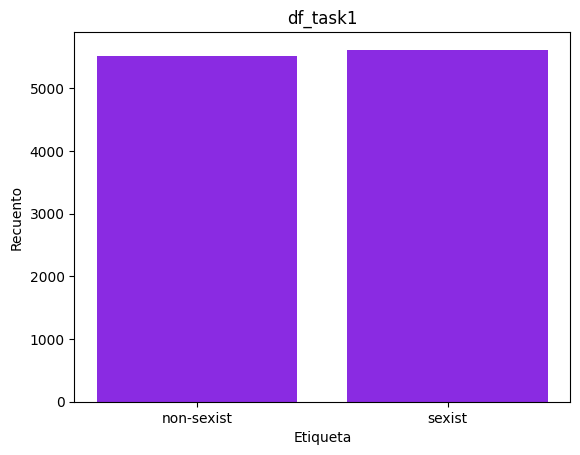

In [ ]:
if 'task1' in dataset_final.columns:
    df_task1=dataset_final[['text','task1']].groupby('task1').count().reset_index()
    df_task1.columns=['label','count']
    df_task1['percentage']=(df_task1['count']/df_task1['count'].sum())*100
    print('DATASET FINAL')
    print(df_task1)


    # Crear el gráfico de barras
    plt.bar(df_task1['label'], df_task1['count'], color='blueviolet')
    plt.xlabel('Etiqueta')
    plt.ylabel('Recuento')
    plt.title('df_task1')
    plt.show()

else:
    print("La columna no está en el DataFrame.")

In [ ]:
if 'task1' in dataset_final_test.columns:
    df_task1=dataset_final_test[['text','task1']].groupby('task1').count().reset_index()
    df_task1.columns=['label','count']
    df_task1['percentage']=(df_task1['count']/df_task1['count'].sum())*100
    print('DATASET FINAL TEST')
    print(df_task1)

else:
    print("La columna no está en el DataFrame.")

DATASET FINAL TEST
        label  count  percentage
0  non-sexist   3342   46.846089
1      sexist   3792   53.153911


In [ ]:
if 'task2' in dataset_final.columns:
    df_task2=dataset_final[['text','task2']].groupby('task2').count().reset_index()
    df_task2.columns=['label','count']
    df_task2['percentage']=(df_task2['count']/df_task2['count'].sum())*100
    print('DATASET FINAL TEST')
    print(df_task2)


else:
    print("La columna no está en el DataFrame.")

DATASET FINAL TEST
                          label  count  percentage
0        ideological-inequality    949    8.530337
1  misogyny-non-sexual-violence   1068    9.600000
2                    non-sexist   5511   49.537079
3               objectification    770    6.921348
4               sexual-violence   1359   12.215730
5        stereotyping-dominance   1468   13.195506


In [ ]:
if 'task2' in dataset_final_test.columns:
    df_task2=dataset_final_test[['text','task2']].groupby('task2').count().reset_index()
    df_task2.columns=['label','count']
    df_task2['percentage']=(df_task2['count']/df_task2['count'].sum())*100
    print('DATASET FINAL TEST')
    print(df_task2)

else:
    print("La columna no está en el DataFrame.")

DATASET FINAL TEST
                          label  count  percentage
0        ideological-inequality    687    9.629941
1  misogyny-non-sexual-violence    744   10.428932
2                    non-sexist   3342   46.846089
3               objectification    522    7.317073
4               sexual-violence    910   12.755817
5        stereotyping-dominance    929   13.022147


DATASET FINAL
  label  count  percentage
0    en   3436   30.885393
1    es   3541   31.829213
2    tr   4148   37.285393


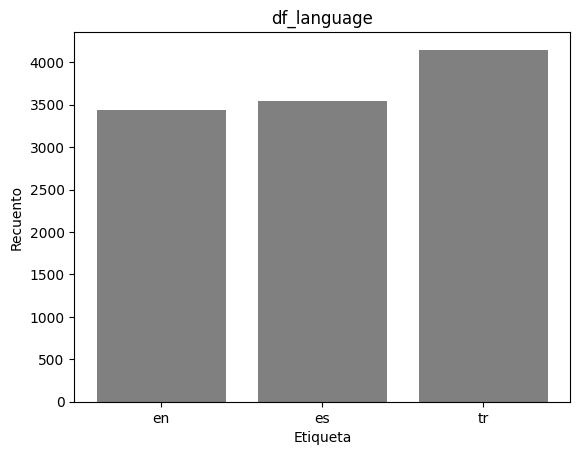

In [ ]:
if 'language' in dataset_final.columns:
    df_language=dataset_final[['text','language']].groupby('language').count().reset_index()
    df_language.columns=['label','count']
    df_language['percentage']=(df_language['count']/df_language['count'].sum())*100
    print('DATASET FINAL')
    print(df_language)


    # Crear el gráfico de barras
    plt.bar(df_language['label'], df_language['count'], color='grey')
    plt.xlabel('Etiqueta')
    plt.ylabel('Recuento')
    plt.title('df_language')
    plt.show()

else:
    print("La columna no está en el DataFrame.")

In [ ]:
if 'language' in dataset_final_test.columns:
    df_language=dataset_final_test[['text','language']].groupby('language').count().reset_index()
    df_language.columns=['label','count']
    df_language['percentage']=(df_language['count']/df_language['count'].sum())*100
    print('DATASET FINAL TEST')
    print(df_language)

else:
    print("La columna no está en el DataFrame.")

DATASET FINAL TEST
  label  count  percentage
0    en   2208   30.950378
1    es   2160   30.277544
2    tr   2766   38.772077


##Preprocesamiento de los datos

  1. Limpieza: eliminación de símbolos y carácteres especiales, URL’s, stopwords
  2. Tokenización: división del texto en tokens (palabras)
  3. Normalización: estandarización de las letras (minusculas)
  4. Stemming: obtención de la raíz de las palabras
  5. Reducción de las palabras a su lema
  6. Vectorización: conversión del texto en representación numérica


In [ ]:
from nltk.corpus import stopwords

stopwords_es = set(stopwords.words('spanish'))
print('\nSpanish stopwords:\n\n', stopwords_es)

stopwords_en = set(stopwords.words('english'))
print('\nEnglish stopwords:\n\n',stopwords_en)

stopwords_tr = set(stopwords.words('turkish'))
print('\nTurkish stopwords:\n\n',stopwords_tr)



Spanish stopwords:

 {'muy', 'estaba', 'hubieses', 'estuvierais', 'seríamos', 'tendrá', 'hemos', 'esas', 'quienes', 'estaréis', 'estuvimos', 'tuyas', 'la', 'habréis', 'habrían', 'las', 'eras', 'estuvieseis', 'esté', 'estaré', 'estará', 'tuvieran', 'ella', 'habían', 'muchos', 'habríamos', 'sentida', 'al', 'uno', 'nuestro', 'hubierais', 'tengáis', 'su', 'éramos', 'hayáis', 'fuesen', 'teníais', 'estaríamos', 'seré', 'estuviste', 'os', 'tendrías', 'eres', 'tuve', 'fueran', 'mis', 'tienen', 'sería', 'habido', 'hubieseis', 'tuvieron', 'sintiendo', 'a', 'no', 'tengo', 'habrás', 'tengas', 'hubimos', 'nuestra', 'erais', 'tuya', 'habías', 'fuiste', 'seas', 'esta', 'o', 'este', 'tendrán', 'estar', 'ante', 'nos', 'estaría', 'mí', 'fuerais', 'tenida', 'estáis', 'estuviéramos', 'le', 'mucho', 'tuviésemos', 'otro', 'somos', 'estados', 'fuimos', 'míos', 'tenido', 'vuestros', 'sentid', 'hasta', 'tendrían', 'sentido', 'ni', 'hubo', 'seremos', 'hubieran', 'tu', 'poco', 'tuviese', 'estoy', 'tuviste', 'se

In [ ]:
def remove_stopwords(text, language):

    # Cargamos las stopwords
    if language == 'english':
            stop_words = set(stopwords.words('english'))
    elif language == 'spanish':
            stop_words = set(stopwords.words('spanish'))
    elif language == 'turkish':
            stop_words = set(nltk.corpus.stopwords.words('turkish'))
    else:
      print('Language not supported')

    # Eliminamos
    cleanTxt = [x for x in text.split() if x not in stop_words]
    return ' '.join(cleanTxt)

def stemming(text, language):

    stemmer = SnowballStemmer(language)
    # Tokenize text
    words = word_tokenize(text)
    # Stem cada palabra
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def stemming_turkish(text):

    stemmer_tr = stemmer('turkish')

    # Dividir el texto en palabras por espacios en blanco
    words = text.split()

    # Aplicar stemming a cada palabra
    stemmed_words = [stemmer_tr.stemWord(word) for word in words]

    return ' '.join(stemmed_words)


def clean(text, language):
    # Eliminamos URLs
    cleanTxt = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Eliminamos hashtags
    cleanTxt = re.sub(r'#\w+', '', cleanTxt)
    # Eliminamos caracteres non-alphanumeric y números
    cleanTxt = re.sub(r'\W+|\d+', ' ', cleanTxt)
    # Minusculas
    cleanTxt = cleanTxt.lower()
    # Stopwords
    cleanTxt = remove_stopwords(cleanTxt, language)
    # Stemming
    if language == 'turkish':
      cleanTxt = stemming_turkish(cleanTxt)
    else:
      cleanTxt = stemming(cleanTxt, language)
    return cleanTxt

In [ ]:
# ENGLISH DATASET
Xtrain_en = []
for text in Xtrain_en_:
    Xtrain_en.append(clean(text, 'english'))

Xtest_en = []
for text in Xtest_en_:
    Xtest_en.append(clean(text, 'english'))


# SPANISH DATASET
Xtrain_es = []
for text in Xtrain_es_:
    Xtrain_es.append(clean(text, 'spanish'))

Xtest_es = []
for text in Xtest_es_:
    Xtest_es.append(clean(text, 'spanish'))


# TURKISH DATASET
Xtrain_tr = []
for text in Xtrain_tr_:
    if isinstance(text, str):
        Xtrain_tr.append(clean(text, 'turkish'))
    else:
        # Convertimos el elemento a cadena de texto
        text_str = str(text)
        Xtrain_tr.append(clean(text_str, 'turkish'))

Xtest_tr = []
for text in Xtest_tr_:
    Xtest_tr.append(clean(text, 'turkish'))



In [ ]:
#ALL LANGUAGES: necesitamos primero limpiar los datos por separado, por eso unimos una vez los datos estan limpios
Xtrain_all = []
Xtrain_all = Xtrain_en + Xtrain_es + Xtrain_tr


Xtest_all = []
Xtest_all = Xtest_en + Xtest_es + Xtest_tr

Comparamos el dataset original con el procesado:

In [ ]:
# Mostramos dos ejemplos de cada

print('ENGLISH')
for i in range(2):
  print('\nOriginal sentence:\n', Xtrain_en_[i])
  print('Label 1:', Y1train_en[i], 'Label 2:', Y2train_en[i])
  print('Processed sentence:\n',Xtrain_en[i])


print('\n\nSPANISH')
for i in range(2):
  print('\nOriginal sentence:\n', Xtrain_es_[i])
  print('Label 1:', Y1train_es[i], 'Label 2:', Y2train_es[i])
  print('Processed sentence:\n',Xtrain_es[i])



print('\n\nTURKISH')
for i in range(2):
  print('\nOriginal sentence:\n', Xtrain_tr_[i])
  print('Label 1:', Y1train_tr[i], 'Label 2:', Y2train_tr[i])
  print('Processed sentence:\n',Xtrain_tr[i])



ENGLISH

Original sentence:
 She calls herself "anti-feminazi" how about shut the fucking up on your vile commentary on an elderly responsible citizen tu sach muuch ghani baawri-bewdi hai bey https://t.co/ZMxTDwsY5D
Label 1: sexist Label 2: ideological-inequality
Processed sentence:
 call anti feminazi shut fuck vile commentari elder respons citizen tu sach muuch ghani baawri bewdi hai bey

Original sentence:
 Now, back to these women, the brave and the beautiful, @Clare_Crawley and @tayshia. These bad ass babes, are deserve so much credit for how this season has gone. As a woman, I’ve learned so much from them and feel more empowered to expect more in future relationships.
Label 1: non-sexist Label 2: non-sexist
Processed sentence:
 back women brave beauti clare_crawley tayshia bad ass babe deserv much credit season gone woman learn much feel empow expect futur relationship


SPANISH

Original sentence:
 Nadie te va a tratar tan bien como un hombre que te lo quiere meter por primera v

##FUNCIONES


MODELOS IMPLEMENTADOS:
- Multinimial Naive bayes
- Random forest
- Gradient Boosting
- Regressión logítica
- KNN




In [ ]:
def BagOfOWords(text):
  #Inicializamos el vector
  vectorizer = CountVectorizer()

  #Ajustamos los datos
  X = vectorizer.fit_transform(text)

  #Obtenemos el vocabulario
  vocabulary = vectorizer.get_feature_names_out()

  # Obtenemos la matriz BoW
  matrix_bow = X.toarray()

  return matrix_bow



def save_excel(accuracy, classification_report_str, confusion_matrix_array, scores, file_name, sheet_name):
    start_row = 0  # Inicializar start_row aquí

    # Crear un DataFrame de pandas para cada conjunto de datos
    data = {
        'Metric': ['Accuracy', 'Classification Report', 'Confusion Matrix', 'Scores', 'Avg score', 'Std'],
        'Value': [accuracy, classification_report_str, str(confusion_matrix_array), scores.tolist(), scores.mean(), scores.std()]
    }
    df = pd.DataFrame(data)

    # Definir la ruta completa del archivo
    file_path = f'/content/drive/Shareddrives/TFG MIREIA/RESULTADOS/{file_name}.xlsx'


    try:
        # Intentar cargar el libro
        try:
            book = load_workbook(file_path)
        except (FileNotFoundError, InvalidFileException):
            book = None

        if book is not None and len(book.sheetnames) > 0:
            with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
                df.to_excel(writer, sheet_name=sheet_name, index=False)
        else:
            with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
                df.to_excel(writer, sheet_name=sheet_name, index=False)

        print(f"Datos guardados en '{sheet_name}' del archivo '{file_name}.xlsx'.")

    except PermissionError:
        print(f"Error: No se pudo acceder o guardar en '{file_name}.xlsx'.")

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Crear un archivo en Google Drive
    file_drive = drive.CreateFile({'title': file_name})
    file_drive.SetContentFile(file_path)
    file_drive.Upload()

    print('Archivo subido a Google Drive con éxito.')




def train_model(model, X_train, y_train, X_test, y_test, file_name, sheet_name):
  #Entrenamos el modelo
  model.fit(X_train, y_train)

  #Testeamos
  predictions = model.predict(X_test)

  # Calcula la precisión del clasificador
  accuracy = accuracy_score(y_test, predictions)
  print('Accuracy:', accuracy)

  # Imprime un reporte de clasificación
  classification_report_str = classification_report(y_test, predictions)
  print(classification_report_str)

  #Imprimimos la confusión matrix
  print('Confusion matrix:')
  confusion_matrix_array = metrics.confusion_matrix(y_test, predictions)
  print(confusion_matrix_array)

  # Cross-validation
  scores = cross_val_score(model, X_train+X_test, y_train+y_test, cv=10, scoring='f1_macro', n_jobs=4)
  print("scores: ", scores)
  print("Avg score: ", scores.mean())
  print("std", scores.std())

  save_excel(accuracy, classification_report_str, confusion_matrix_array, scores, file_name, sheet_name)

In [ ]:
def print_pipeline(pipeline):

  print('\n')

  max_step_name_length = max(len(name) for name, _ in pipeline.steps)

  # Imprime el pipeline
  print("Pipeline:")
  print("-" * (max_step_name_length + 12))
  for name, _ in pipeline.steps:
      padding = " " * (max_step_name_length - len(name))
      print("| " + name + padding + " |")
  print("-" * (max_step_name_length + 12))

##MULTINOMIAL NAIVE BAYES

In [ ]:
def modelo_Naive_Bayes(X_train, y_train, X_test, y_test, language):
  num_features=50

  #Multinomial Naive Bayes
  naive_bayes_classifier = MultinomialNB()

  #### VECTORIZACIÓN ####
  #TfidfVectorizer
  tfidf = TfidfTransformer()
  #CountVectorizer
  count_vectorizer = CountVectorizer()
  #hash
  hash_vectorizer = HashingVectorizer()

  #### SELECCIÓN DE CARACTERÍSTICAS ####
  #select k best
  select_k_best = SelectKBest(score_func=chi2, k=num_features)

  ### CONFIGURACIÓN DEL FICHERO ###
  # Nombre del fichero
  # Obtener la fecha y hora actuales
  now = datetime.now()
  formatted_date = now.strftime("%H:%M %d_%m_%y")

  # Crear un nombre de archivo con el formato deseado
  file_name = f"Naive_Bayes_{language}_{formatted_date}"

  #Pipeline 1
  pipeline1 = Pipeline([
      ('countvectorizer', count_vectorizer),
      ('selectkbest', select_k_best),
      ('classifier', naive_bayes_classifier),
  ])

  print_pipeline(pipeline1)
  train_model(pipeline1, X_train, y_train, X_test, y_test, file_name, "Pipeline 1 - Results")

   #Pipeline 2
  pipeline2 = Pipeline([
      ('countvectorizer', count_vectorizer),
      ('classifier', naive_bayes_classifier),
  ])

  print_pipeline(pipeline2)
  train_model(pipeline2, X_train, y_train, X_test, y_test, file_name, "Pipeline 2 - Results")

  #Pipeline 3
  pipeline3 = Pipeline([
    ('countvectorizer', count_vectorizer),
    ('tfidf', tfidf),
    ('classifier', naive_bayes_classifier),
  ])

  print_pipeline(pipeline3)
  train_model(pipeline3, X_train, y_train, X_test, y_test, file_name, "Pipeline 3 - Results")


###Task 1

Primero vemos el resultado obtenido con el dataset en inglés.

In [ ]:
modelo_Naive_Bayes(Xtrain_en, Y1train_en, Xtest_en, Y1test_en, 'english')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.636322463768116
              precision    recall  f1-score   support

  non-sexist       0.59      0.80      0.68      1050
      sexist       0.73      0.49      0.58      1158

    accuracy                           0.64      2208
   macro avg       0.66      0.64      0.63      2208
weighted avg       0.66      0.64      0.63      2208

Confusion matrix:
[[842 208]
 [595 563]]
scores:  [0.6903949  0.68129513 0.67623417 0.69497803 0.65333169 0.68111674
 0.68284775 0.67225635 0.68318166 0.67523686]
Avg score:  0.6790873265533104
std 0.010738970051710378
Datos guardados en 'Pipeline 1 - Results' del archivo 'Naive_Bayes_english_18:42 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.6743659420289855
              precision

A continucación vemos el resultado obtenido en español:

In [ ]:
modelo_Naive_Bayes(Xtrain_es, Y1train_es, Xtest_es, Y1test_es, 'spanish')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.6731481481481482
              precision    recall  f1-score   support

  non-sexist       0.64      0.72      0.68      1037
      sexist       0.71      0.63      0.67      1123

    accuracy                           0.67      2160
   macro avg       0.68      0.68      0.67      2160
weighted avg       0.68      0.67      0.67      2160

Confusion matrix:
[[751 286]
 [420 703]]
scores:  [0.61586677 0.62150519 0.56311824 0.61876623 0.59910486 0.51071985
 0.60631255 0.58360553 0.6024447  0.61674109]
Avg score:  0.5938185018474282
std 0.03257478841001471
Datos guardados en 'Pipeline 1 - Results' del archivo 'Naive_Bayes_spanish_18:42 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.6953703703703704
              precision

Hacemos lo mismo con el dataset en turco

In [ ]:
modelo_Naive_Bayes(Xtrain_tr, Y1train_tr, Xtest_tr, Y1test_tr, 'turkish')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.5979754157628344
              precision    recall  f1-score   support

  non-sexist       0.61      0.31      0.41      1255
      sexist       0.59      0.84      0.70      1511

    accuracy                           0.60      2766
   macro avg       0.60      0.57      0.55      2766
weighted avg       0.60      0.60      0.57      2766

Confusion matrix:
[[ 384  871]
 [ 241 1270]]
scores:  [0.57208268 0.57355769 0.55830654 0.525806   0.51050284 0.55401411
 0.55091268 0.54301551 0.55488614 0.53572933]
Avg score:  0.5478813534153879
std 0.018722585459946192
Datos guardados en 'Pipeline 1 - Results' del archivo 'Naive_Bayes_turkish_18:42 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.7870571221981201
              prec

Hacemos lo mismo con el dataset sin separar los idiomas

In [ ]:
modelo_Naive_Bayes(Xtrain_all, Y1train_all, Xtest_all, Y1test_all, 'all')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.49102887580599947
              precision    recall  f1-score   support

  non-sexist       0.40      0.17      0.24      3342
      sexist       0.51      0.77      0.62      3792

    accuracy                           0.49      7134
   macro avg       0.46      0.47      0.43      7134
weighted avg       0.46      0.49      0.44      7134

Confusion matrix:
[[ 578 2764]
 [ 867 2925]]
scores:  [0.40995236 0.42500077 0.40622577 0.44730138 0.53520768 0.5066356
 0.40405448 0.40467928 0.47654485 0.50219256]
Avg score:  0.4517794738292394
std 0.04709794821102818
Datos guardados en 'Pipeline 1 - Results' del archivo 'Naive_Bayes_all_18:42 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.6792823100644799
              precision

###Task 2


Primero vemos el resultado obtenido con el dataset en inglés.

In [ ]:
modelo_Naive_Bayes(Xtrain_en, Y2train_en, Xtest_en, Y2test_en, 'english')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.5643115942028986
                              precision    recall  f1-score   support

      ideological-inequality       0.74      0.40      0.52       333
misogyny-non-sexual-violence       0.43      0.11      0.18       215
                  non-sexist       0.56      0.87      0.68      1050
             objectification       0.50      0.27      0.35       150
             sexual-violence       0.42      0.28      0.33       198
      stereotyping-dominance       0.57      0.30      0.39       262

                    accuracy                           0.56      2208
                   macro avg       0.54      0.37      0.41      2208
                weighted avg       0.56      0.56      0.52      2208

Confusion matrix:
[[133   4 186   1   4   5]
 [  7  24 159   9  10   6]
 [ 27  15 915  20  47  26]
 [  1   2  75  40  14  18]
 [  2   8 122 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


scores:  [0.14890542 0.12990748 0.1535112  0.15117506 0.14228046 0.13739462
 0.13075126 0.13214376 0.12679247 0.14073342]
Avg score:  0.13935951643635094
std 0.009048328979694244
Datos guardados en 'Pipeline 3 - Results' del archivo 'Naive_Bayes_english_18:43 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


A continucación vemos el resultado obtenido en español:

In [ ]:
modelo_Naive_Bayes(Xtrain_es, Y2train_es, Xtest_es, Y2test_es, 'spanish')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.5828703703703704
                              precision    recall  f1-score   support

      ideological-inequality       0.85      0.25      0.38       288
misogyny-non-sexual-violence       0.65      0.27      0.38       257
                  non-sexist       0.55      0.93      0.70      1037
             objectification       0.62      0.25      0.35       174
             sexual-violence       0.69      0.19      0.30       202
      stereotyping-dominance       0.69      0.34      0.46       202

                    accuracy                           0.58      2160
                   macro avg       0.68      0.37      0.43      2160
                weighted avg       0.64      0.58      0.53      2160

Confusion matrix:
[[ 71   0 211   3   1   2]
 [  5  69 177   3   1   2]
 [  7  19 969   8  15  19]
 [  1   8 116  43   0   6]
 [  0   2 153 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


scores:  [0.18933443 0.16011161 0.17175026 0.12568627 0.13598127 0.15906372
 0.14844859 0.14821146 0.13844908 0.12805634]
Avg score:  0.15050930401303692
std 0.01900081064511046
Datos guardados en 'Pipeline 3 - Results' del archivo 'Naive_Bayes_spanish_18:43 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Hacemos lo mismo con el dataset en turco

In [ ]:
modelo_Naive_Bayes(Xtrain_tr, Y2train_tr, Xtest_tr, Y2test_tr, 'turkish')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.6073752711496746
                              precision    recall  f1-score   support

      ideological-inequality       0.83      0.08      0.14        66
misogyny-non-sexual-violence       0.49      0.14      0.21       272
                  non-sexist       0.59      0.93      0.72      1255
             objectification       0.56      0.15      0.23       198
             sexual-violence       0.88      0.66      0.75       510
      stereotyping-dominance       0.39      0.23      0.29       465

                    accuracy                           0.61      2766
                   macro avg       0.62      0.36      0.39      2766
                weighted avg       0.60      0.61      0.56      2766

Confusion matrix:
[[   5    9   30    1    1   20]
 [   0   37  170    4   10   51]
 [   0    1 1164    8   13   69]
 [   0   12  133   29  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

      ideological-inequality       0.00      0.00      0.00        66
misogyny-non-sexual-violence       0.41      0.13      0.20       272
                  non-sexist       0.68      0.90      0.78      1255
             objectification       0.81      0.11      0.19       198
             sexual-violence       0.85      0.84      0.84       510
      stereotyping-dominance       0.42      0.45      0.43       465

                    accuracy                           0.66      2766
                   macro avg       0.53      0.40      0.41      2766
                weighted avg       0.64      0.66      0.61      2766

Confusion matrix:
[[   0    7   24    0    1   34]
 [   0   36  115    2   13  106]
 [   0   11 1132    2   22   88]
 [   0   15  100   21   26   36]
 [   0    4   56    1  426   23]
 [   0   14  231    0   11  209]]
scores:  [0.42028335 0.4393521  0.42270593 0.43936063 0.40514031 0.4429442
 0.44

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

      ideological-inequality       0.00      0.00      0.00        66
misogyny-non-sexual-violence       1.00      0.00      0.01       272
                  non-sexist       0.53      0.99      0.69      1255
             objectification       1.00      0.01      0.02       198
             sexual-violence       0.92      0.69      0.79       510
      stereotyping-dominance       0.58      0.07      0.12       465

                    accuracy                           0.59      2766
                   macro avg       0.67      0.29      0.27      2766
                weighted avg       0.68      0.59      0.48      2766

Confusion matrix:
[[   0    0   63    0    0    3]
 [   0    1  255    0    8    8]
 [   0    0 1240    0    7    8]
 [   0    0  181    2   12    3]
 [   0    0  157    0  353    0]
 [   0    0  429    0    5   31]]
scores:  [0.29860627 0.27981238 0.28034712 0.29063645 0.28869921 0.28751331
 0.2

Hacemos lo mismo con el dataset sin separar los idiomas

In [ ]:
modelo_Naive_Bayes(Xtrain_all, Y2train_all, Xtest_all, Y2test_all, 'all')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.5431735351836277
                              precision    recall  f1-score   support

      ideological-inequality       0.85      0.21      0.33       687
misogyny-non-sexual-violence       0.00      0.00      0.00       744
                  non-sexist       0.52      0.98      0.68      3342
             objectification       0.46      0.07      0.13       522
             sexual-violence       0.88      0.40      0.55       910
      stereotyping-dominance       0.47      0.05      0.10       929

                    accuracy                           0.54      7134
                   macro avg       0.53      0.29      0.30      7134
                weighted avg       0.53      0.54      0.44      7134

Confusion matrix:
[[ 143    0  534    4    2    4]
 [   6    0  706   10    9   13]
 [  16    2 3281   11   14   18]
 [   2    0  463   39  

##K NEAREST NEIGHBORS

In [ ]:
def modelo_KNN(X_train, y_train, X_test, y_test, language):
  num_features=50

  #Multinomial Naive Bayes
  KNN_classifier = KNeighborsClassifier()

  #### VECTORIZACIÓN ####
  #TfidfVectorizer
  tfidf = TfidfTransformer()
  #CountVectorizer
  count_vectorizer = CountVectorizer()
  #hash
  hash_vectorizer = HashingVectorizer()

  #### SELECCIÓN DE CARACTERÍSTICAS ####
  #select k best
  select_k_best = SelectKBest(score_func=chi2, k=num_features)

   ### CONFIGURACIÓN DEL FICHERO ###
  # Nombre del fichero
  # Obtener la fecha y hora actuales
  now = datetime.now()
  formatted_date = now.strftime("%H:%M %d_%m_%y")

  # Crear un nombre de archivo con el formato deseado
  file_name = f"KNN_{language}_{formatted_date}"

  #Pipeline 1
  pipeline1 = Pipeline([
      ('countvectorizer', count_vectorizer),
      ('selectkbest', select_k_best),
      ('classifier', KNN_classifier),
  ])

  print_pipeline(pipeline1)
  train_model(pipeline1, X_train, y_train, X_test, y_test, file_name, "Pipeline 1 - Results")

   #Pipeline 2
  pipeline2 = Pipeline([
      ('countvectorizer', count_vectorizer),
      ('classifier', KNN_classifier),
  ])

  print_pipeline(pipeline2)
  train_model(pipeline2, X_train, y_train, X_test, y_test, file_name, "Pipeline 2 - Results")

  #Pipeline 3
  pipeline3 = Pipeline([
    ('countvectorizer', count_vectorizer),
    ('tfidf', tfidf),
    ('classifier', KNN_classifier),
  ])

  print_pipeline(pipeline3)
  train_model(pipeline3, X_train, y_train, X_test, y_test, file_name, "Pipeline 3 - Results")


###Task 1

Primero vemos el resultado obtenido con el dataset en inglés.

In [ ]:
modelo_KNN(Xtrain_en, Y1train_en, Xtest_en, Y1test_en, 'english')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.644927536231884
              precision    recall  f1-score   support

  non-sexist       0.61      0.71      0.65      1050
      sexist       0.69      0.59      0.64      1158

    accuracy                           0.64      2208
   macro avg       0.65      0.65      0.64      2208
weighted avg       0.65      0.64      0.64      2208

Confusion matrix:
[[742 308]
 [476 682]]
scores:  [0.70264648 0.51946844 0.6805744  0.6991141  0.6575395  0.67256894
 0.60187729 0.68976199 0.66729059 0.64325922]
Avg score:  0.6534100957349277
std 0.05277144795562045
Datos guardados en 'Pipeline 1 - Results' del archivo 'KNN_english_18:44 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.613677536231884
              precision    recall

A continucación vemos el resultado obtenido en español:

In [ ]:
modelo_KNN(Xtrain_es, Y1train_es, Xtest_es, Y1test_es, 'spanish')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.6449074074074074
              precision    recall  f1-score   support

  non-sexist       0.58      0.93      0.71      1037
      sexist       0.85      0.38      0.53      1123

    accuracy                           0.64      2160
   macro avg       0.72      0.66      0.62      2160
weighted avg       0.72      0.64      0.62      2160

Confusion matrix:
[[962  75]
 [692 431]]
scores:  [0.61297899 0.67927632 0.58930084 0.64333602 0.68942684 0.6310293
 0.64382269 0.69828518 0.67130227 0.6900625 ]
Avg score:  0.654882093449826
std 0.03472877540890538
Datos guardados en 'Pipeline 1 - Results' del archivo 'KNN_spanish_18:45 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.6074074074074074
              precision    recall

Hacemos lo mismo con el dataset en turco

In [ ]:
modelo_KNN(Xtrain_tr, Y1train_tr, Xtest_tr, Y1test_tr, 'turkish')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.7801879971077368
              precision    recall  f1-score   support

  non-sexist       0.73      0.82      0.77      1255
      sexist       0.83      0.75      0.79      1511

    accuracy                           0.78      2766
   macro avg       0.78      0.78      0.78      2766
weighted avg       0.79      0.78      0.78      2766

Confusion matrix:
[[1026  229]
 [ 379 1132]]
scores:  [0.7360218  0.57371663 0.78145921 0.54558173 0.52229515 0.79698649
 0.55436216 0.79977575 0.5330915  0.56389642]
Avg score:  0.6407186842044937
std 0.11450612353941887
Datos guardados en 'Pipeline 1 - Results' del archivo 'KNN_turkish_18:45 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.5683297180043384
              precision    

Hacemos lo mismo con el dataset sin separar los idiomas

In [ ]:
modelo_KNN(Xtrain_all, Y1train_all, Xtest_all, Y1test_all, 'all')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.6201289599102887
              precision    recall  f1-score   support

  non-sexist       0.56      0.91      0.69      3342
      sexist       0.82      0.37      0.51      3792

    accuracy                           0.62      7134
   macro avg       0.69      0.64      0.60      7134
weighted avg       0.70      0.62      0.59      7134

Confusion matrix:
[[3035  307]
 [2403 1389]]
scores:  [0.56207783 0.48352096 0.34007951 0.66049438 0.52012413 0.76703947
 0.41002721 0.34085116 0.70251647 0.76035707]
Avg score:  0.5547088186037852
std 0.15474653969384067
Datos guardados en 'Pipeline 1 - Results' del archivo 'KNN_all_18:46 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.5583123072610037
              precision    reca

###Task 2


Primero vemos el resultado obtenido con el dataset en inglés.

In [ ]:
modelo_KNN(Xtrain_en, Y2train_en, Xtest_en, Y2test_en, 'english')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.5520833333333334
                              precision    recall  f1-score   support

      ideological-inequality       0.65      0.39      0.48       333
misogyny-non-sexual-violence       0.31      0.27      0.29       215
                  non-sexist       0.59      0.83      0.69      1050
             objectification       0.37      0.27      0.31       150
             sexual-violence       0.49      0.34      0.40       198
      stereotyping-dominance       0.54      0.20      0.29       262

                    accuracy                           0.55      2208
                   macro avg       0.49      0.38      0.41      2208
                weighted avg       0.54      0.55      0.52      2208

Confusion matrix:
[[129  23 164   3   5   9]
 [  9  58 119  11  13   5]
 [ 36  64 872  27  36  15]
 [  3  17  64  41  13  12]
 [  3  12 105 

A continucación vemos el resultado obtenido en español:

In [ ]:
modelo_KNN(Xtrain_es, Y2train_es, Xtest_es, Y2test_es, 'spanish')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.5476851851851852
                              precision    recall  f1-score   support

      ideological-inequality       0.64      0.42      0.51       288
misogyny-non-sexual-violence       0.38      0.34      0.36       257
                  non-sexist       0.59      0.80      0.68      1037
             objectification       0.61      0.22      0.33       174
             sexual-violence       0.81      0.08      0.15       202
      stereotyping-dominance       0.36      0.44      0.40       202

                    accuracy                           0.55      2160
                   macro avg       0.56      0.39      0.40      2160
                weighted avg       0.57      0.55      0.51      2160

Confusion matrix:
[[122   4 140   2   0  20]
 [ 14  88 108   3   1  43]
 [ 28  99 828   4   2  76]
 [  8  21  96  39   1   9]
 [ 10  10 147 

Hacemos lo mismo con el dataset en turco

In [ ]:
modelo_KNN(Xtrain_tr, Y2train_tr, Xtest_tr, Y2test_tr, 'turkish')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.6095444685466378
                              precision    recall  f1-score   support

      ideological-inequality       0.11      0.14      0.12        66
misogyny-non-sexual-violence       0.31      0.17      0.21       272
                  non-sexist       0.63      0.89      0.74      1255
             objectification       0.63      0.11      0.19       198
             sexual-violence       0.90      0.67      0.77       510
      stereotyping-dominance       0.42      0.32      0.36       465

                    accuracy                           0.61      2766
                   macro avg       0.50      0.38      0.40      2766
                weighted avg       0.60      0.61      0.58      2766

Confusion matrix:
[[   9   10   21    1    0   25]
 [  18   45  143    4    7   55]
 [   9   19 1122    2   11   92]
 [  22   23  101   22  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


scores:  [0.22185324 0.21600776 0.22897484 0.20974508 0.23968133 0.22481836
 0.21882401 0.21288688 0.22509519 0.19792668]
Avg score:  0.21958133793051543
std 0.010858517407873114
Datos guardados en 'Pipeline 3 - Results' del archivo 'KNN_turkish_18:56 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Hacemos lo mismo con el dataset sin separar los idiomas

In [ ]:
modelo_KNN(Xtrain_all, Y2train_all, Xtest_all, Y2test_all,'all')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.18769273899635547
                              precision    recall  f1-score   support

      ideological-inequality       0.57      0.27      0.37       687
misogyny-non-sexual-violence       0.11      0.85      0.19       744
                  non-sexist       0.21      0.02      0.04      3342
             objectification       0.44      0.07      0.12       522
             sexual-violence       0.88      0.41      0.56       910
      stereotyping-dominance       0.31      0.04      0.07       929

                    accuracy                           0.19      7134
                   macro avg       0.42      0.28      0.23      7134
                weighted avg       0.35      0.19      0.16      7134

Confusion matrix:
[[ 188  334  153    4    1    7]
 [  38  631   37    7    9   22]
 [  33 3172   78   13   16   30]
 [  42  412    9   38 

In [ ]:
####################################################

##RANDOM FOREST

In [ ]:
def modelo_Random_Forest(X_train, y_train, X_test, y_test, language):
  num_features=50

  #Multinomial Naive Bayes
  random_forest_classifier = RandomForestClassifier()

  #### VECTORIZACIÓN ####
  #TfidfVectorizer
  tfidf = TfidfTransformer()
  #CountVectorizer
  count_vectorizer = CountVectorizer()
  #hash
  hash_vectorizer = HashingVectorizer()

  #### SELECCIÓN DE CARACTERÍSTICAS ####
  #select k best
  select_k_best = SelectKBest(score_func=chi2, k=num_features)

  ### CONFIGURACIÓN DEL FICHERO ###
  # Nombre del fichero
  # Obtener la fecha y hora actuales
  now = datetime.now()
  formatted_date = now.strftime("%H:%M %d_%m_%y")

  # Crear un nombre de archivo con el formato deseado
  file_name = f"Random_Forest_{language}_{formatted_date}"

  #Pipeline 1
  pipeline1 = Pipeline([
      ('countvectorizer', count_vectorizer),
      ('selectkbest', select_k_best),
      ('classifier', random_forest_classifier),
  ])

  print_pipeline(pipeline1)
  train_model(pipeline1, X_train, y_train, X_test, y_test, file_name, "Pipeline 1 - Results")


   #Pipeline 2
  pipeline2 = Pipeline([
      ('countvectorizer', count_vectorizer),
      ('classifier', random_forest_classifier),
  ])

  print_pipeline(pipeline2)
  train_model(pipeline2, X_train, y_train, X_test, y_test, file_name, "Pipeline 2 - Results")


  #Pipeline 3
  pipeline3 = Pipeline([
    ('countvectorizer', count_vectorizer),
    ('tfidf', tfidf),
    ('classifier', random_forest_classifier),
  ])

  print_pipeline(pipeline3)
  train_model(pipeline3, X_train, y_train, X_test, y_test, file_name, "Pipeline 3 - Results")



###Task 1

Primero vemos el resultado obtenido con el dataset en inglés.

In [ ]:
#modelo_Random_Forest(Xtrain_en, Y1train_en, Xtest_en, Y1test_en, 'english')

A continucación vemos el resultado obtenido en español:

In [ ]:
#modelo_Random_Forest(Xtrain_es, Y1train_es, Xtest_es, Y1test_es, 'spanish')

Hacemos lo mismo con el dataset en turco

In [ ]:
#modelo_Random_Forest(Xtrain_tr, Y1train_tr, Xtest_tr, Y1test_tr, 'turkish')

Hacemos lo mismo con el dataset sin separar los idiomas

In [ ]:
modelo_Random_Forest(Xtrain_all, Y1train_all, Xtest_all, Y1test_all, 'all')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.664143537987104
              precision    recall  f1-score   support

  non-sexist       0.60      0.84      0.70      3342
      sexist       0.78      0.51      0.62      3792

    accuracy                           0.66      7134
   macro avg       0.69      0.67      0.66      7134
weighted avg       0.70      0.66      0.66      7134

Confusion matrix:
[[2798  544]
 [1852 1940]]
scores:  [0.56354318 0.57271294 0.55776854 0.66901864 0.7754523  0.77820206
 0.41274725 0.50804042 0.70488224 0.7864184 ]
Avg score:  0.6328785969282837
std 0.12232026660075195
Datos guardados en 'Pipeline 1 - Results' del archivo 'Random_Forest_all_18:59 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.7593215587328287
              precisio

###Task 2


Primero vemos el resultado obtenido con el dataset en inglés.

In [ ]:
#modelo_Random_Forest(Xtrain_en, Y2train_en, Xtest_en, Y2test_en, 'english')

A continucación vemos el resultado obtenido en español:

In [ ]:
#modelo_Random_Forest(Xtrain_es, Y2train_es, Xtest_es, Y2test_es, 'spanish')

Hacemos lo mismo con el dataset en turco

In [ ]:
#modelo_Random_Forest(Xtrain_tr, Y2train_tr, Xtest_tr, Y2test_tr, 'turkish')

Hacemos lo mismo con el dataset sin separar los idiomas

In [ ]:
modelo_Random_Forest(Xtrain_all, Y2train_all, Xtest_all, Y2test_all, 'all')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.5737314269694421
                              precision    recall  f1-score   support

      ideological-inequality       0.77      0.45      0.57       687
misogyny-non-sexual-violence       0.24      0.01      0.01       744
                  non-sexist       0.55      0.95      0.70      3342
             objectification       0.39      0.14      0.21       522
             sexual-violence       0.86      0.43      0.57       910
      stereotyping-dominance       0.47      0.14      0.22       929

                    accuracy                           0.57      7134
                   macro avg       0.55      0.35      0.38      7134
                weighted avg       0.56      0.57      0.50      7134

Confusion matrix:
[[ 312    0  350   14    2    9]
 [  19    4  627   38   10   46]
 [  49    3 3182   18   23   67]
 [   7    5  404   74  

In [ ]:
#######################################

##GRADIENT BOOSTING

In [ ]:
def modelo_Gradient_Boosting(X_train, y_train, X_test, y_test, language):
  num_features=50

  #Multinomial Naive Bayes
  GB_classifier = GradientBoostingClassifier()

  #### VECTORIZACIÓN ####
  #TfidfVectorizer
  tfidf = TfidfTransformer()
  #CountVectorizer
  count_vectorizer = CountVectorizer()
  #hash
  hash_vectorizer = HashingVectorizer()

  #### SELECCIÓN DE CARACTERÍSTICAS ####
  #select k best
  select_k_best = SelectKBest(score_func=chi2, k=num_features)

   ### CONFIGURACIÓN DEL FICHERO ###
  # Nombre del fichero
  # Obtener la fecha y hora actuales
  now = datetime.now()
  formatted_date = now.strftime("%H:%M %d_%m_%y")

  # Crear un nombre de archivo con el formato deseado
  file_name = f"Gradient_{language}_{formatted_date}"

  #Pipeline 1
  pipeline1 = Pipeline([
      ('countvectorizer', count_vectorizer),
      ('selectkbest', select_k_best),
      ('classifier', GB_classifier),
  ])

  print_pipeline(pipeline1)
  train_model(pipeline1, X_train, y_train, X_test, y_test, file_name, "Pipeline 1 - Results")


   #Pipeline 2
  pipeline2 = Pipeline([
      ('countvectorizer', count_vectorizer),
      ('classifier', GB_classifier),
  ])

  print_pipeline(pipeline2)
  train_model(pipeline2, X_train, y_train, X_test, y_test, file_name, "Pipeline 2 - Results")


  #Pipeline 3
  pipeline3 = Pipeline([
    ('countvectorizer', count_vectorizer),
    ('tfidf', tfidf),
    ('classifier', GB_classifier),
  ])

  print_pipeline(pipeline3)
  train_model(pipeline3, X_train, y_train, X_test, y_test, file_name, "Pipeline 3 - Results")



###Task 1

Primero vemos el resultado obtenido con el dataset en inglés.

In [ ]:
#modelo_Gradient_Boosting(Xtrain_en, Y1train_en, Xtest_en, Y1test_en, 'english')

A continucación vemos el resultado obtenido en español:

In [ ]:
#modelo_Gradient_Boosting(Xtrain_es, Y1train_es, Xtest_es, Y1test_es, 'spanish')

Hacemos lo mismo con el dataset en turco

In [ ]:
#modelo_Gradient_Boosting(Xtrain_tr, Y1train_tr, Xtest_tr, Y1test_tr, 'turkish')

Hacemos lo mismo con el dataset sin separar los idiomas

In [ ]:
modelo_Gradient_Boosting(Xtrain_all, Y1train_all, Xtest_all, Y1test_all, 'all')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.6644238856181666
              precision    recall  f1-score   support

  non-sexist       0.60      0.83      0.70      3342
      sexist       0.78      0.52      0.62      3792

    accuracy                           0.66      7134
   macro avg       0.69      0.67      0.66      7134
weighted avg       0.70      0.66      0.66      7134

Confusion matrix:
[[2785  557]
 [1837 1955]]
scores:  [0.56354318 0.57271294 0.55844255 0.66788572 0.77818876 0.77983715
 0.41206757 0.50761593 0.7092175  0.77709339]
Avg score:  0.6326604692937332
std 0.12205682711007824
Datos guardados en 'Pipeline 1 - Results' del archivo 'Gradient_all_19:49 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.7130641996075133
              precision   

###Task 2


Primero vemos el resultado obtenido con el dataset en inglés.

In [ ]:
#modelo_Gradient_Boosting(Xtrain_en, Y2train_en, Xtest_en, Y2test_en, 'english')

A continucación vemos el resultado obtenido en español:

In [ ]:
#modelo_Gradient_Boosting(Xtrain_es, Y2train_es, Xtest_es, Y2test_es, 'spanish')

Hacemos lo mismo con el dataset en turco

In [ ]:
#modelo_Gradient_Boosting(Xtrain_tr, Y2train_tr, Xtest_tr, Y2test_tr, 'turkish')

Hacemos lo mismo con el dataset sin separar los idiomas

In [ ]:
modelo_Gradient_Boosting(Xtrain_all, Y2train_all, Xtest_all, Y2test_all, 'all')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.5728903840762546
                              precision    recall  f1-score   support

      ideological-inequality       0.78      0.45      0.57       687
misogyny-non-sexual-violence       0.24      0.01      0.01       744
                  non-sexist       0.55      0.95      0.70      3342
             objectification       0.38      0.14      0.21       522
             sexual-violence       0.87      0.42      0.56       910
      stereotyping-dominance       0.46      0.15      0.23       929

                    accuracy                           0.57      7134
                   macro avg       0.55      0.35      0.38      7134
                weighted avg       0.56      0.57      0.50      7134

Confusion matrix:
[[ 311    1  350   14    2    9]
 [  18    4  622   39   11   50]
 [  48    5 3182   19   15   73]
 [   7    5  402   73  

In [ ]:
##############################################

##REGRESIÓN LOGÍSTICA

In [ ]:
def modelo_Regresion(X_train, y_train, X_test, y_test, language):
  num_features=50

  #Multinomial Naive Bayes
  regression_classifier = LogisticRegression()

  #### VECTORIZACIÓN ####
  #TfidfVectorizer
  tfidf = TfidfTransformer()
  #CountVectorizer
  count_vectorizer = CountVectorizer()
  #hash
  hash_vectorizer = HashingVectorizer()

  #### SELECCIÓN DE CARACTERÍSTICAS ####
  #select k best
  select_k_best = SelectKBest(score_func=chi2, k=num_features)


  ### CONFIGURACIÓN DEL FICHERO ###
  # Nombre del fichero
  # Obtener la fecha y hora actuales
  now = datetime.now()
  formatted_date = now.strftime("%H:%M %d_%m_%y")

  # Crear un nombre de archivo con el formato deseado
  file_name = f"Regresion_{language}_{formatted_date}"


  #Pipeline 1
  pipeline1 = Pipeline([
      ('countvectorizer', count_vectorizer),
      ('selectkbest', select_k_best),
      ('classifier', regression_classifier),
  ])

  print_pipeline(pipeline1)
  train_model(pipeline1, X_train, y_train, X_test, y_test, file_name, "Pipeline 1 - Results")

   #Pipeline 2
  pipeline2 = Pipeline([
      ('countvectorizer', count_vectorizer),
      ('classifier', regression_classifier),
  ])

  print_pipeline(pipeline2)
  train_model(pipeline2, X_train, y_train, X_test, y_test, file_name, "Pipeline 2 - Results")

  #Pipeline 3
  pipeline3 = Pipeline([
    ('countvectorizer', count_vectorizer),
    ('tfidf', tfidf),
    ('classifier', regression_classifier),
  ])

  print_pipeline(pipeline3)
  train_model(pipeline3, X_train, y_train, X_test, y_test, file_name, "Pipeline 3 - Results")


###Task 1

Primero vemos el resultado obtenido con el dataset en inglés.

In [ ]:
#modelo_Regresion(Xtrain_en, Y1train_en, Xtest_en, Y1test_en, 'english')

A continucación vemos el resultado obtenido en español:

In [ ]:
#modelo_Regresion(Xtrain_es, Y1train_es, Xtest_es, Y1test_es, 'spanish')

Hacemos lo mismo con el dataset en turco

In [ ]:
#modelo_Regresion(Xtrain_tr, Y1train_tr, Xtest_tr, Y1test_tr, 'turkish')

Hacemos lo mismo con el dataset sin separar los idiomas

In [ ]:
modelo_Regresion(Xtrain_all, Y1train_all, Xtest_all, Y1test_all, 'all')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------
Accuracy: 0.6656854499579479
              precision    recall  f1-score   support

  non-sexist       0.60      0.83      0.70      3342
      sexist       0.78      0.52      0.62      3792

    accuracy                           0.67      7134
   macro avg       0.69      0.68      0.66      7134
weighted avg       0.70      0.67      0.66      7134

Confusion matrix:
[[2773  569]
 [1816 1976]]
scores:  [0.56354318 0.57271294 0.55844255 0.67213064 0.7798147  0.78136835
 0.41070756 0.5083934  0.70775727 0.78860492]
Avg score:  0.6343475519856538
std 0.12403251280211923
Datos guardados en 'Pipeline 1 - Results' del archivo 'Regresion_all_20:16 21_05_24.xlsx'.
Archivo subido a Google Drive con éxito.


Pipeline:
---------------------------
| countvectorizer |
| classifier      |
---------------------------
Accuracy: 0.751892346509672
              precision   

###Task 2


Primero vemos el resultado obtenido con el dataset en inglés.

In [ ]:
#modelo_Regresion(Xtrain_en, Y2train_en, Xtest_en, Y2test_en, 'english')

A continucación vemos el resultado obtenido en español:

In [ ]:
#modelo_Regresion(Xtrain_es, Y2train_es, Xtest_es, Y2test_es, 'spanish')

Hacemos lo mismo con el dataset en turco

In [ ]:
#modelo_Regresion(Xtrain_tr, Y2train_tr, Xtest_tr, Y2test_tr, 'turkish')

Hacemos lo mismo con el dataset sin separar los idiomas

In [ ]:
modelo_Regresion(Xtrain_all, Y2train_all, Xtest_all, Y2test_all, 'all')



Pipeline:
---------------------------
| countvectorizer |
| selectkbest     |
| classifier      |
---------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.5528455284552846
                              precision    recall  f1-score   support

      ideological-inequality       0.81      0.27      0.40       687
misogyny-non-sexual-violence       0.28      0.05      0.08       744
                  non-sexist       0.53      0.97      0.69      3342
             objectification       0.45      0.07      0.13       522
             sexual-violence       0.87      0.42      0.56       910
      stereotyping-dominance       0.42      0.09      0.14       929

                    accuracy                           0.55      7134
                   macro avg       0.56      0.31      0.33      7134
                weighted avg       0.56      0.55      0.47      7134

Confusion matrix:
[[ 184   14  475    4    3    7]
 [   8   37  650    8   13   28]
 [  23   13 3226   13   12   55]
 [   5   40  413   38   13   13]
 [   2    1  513    7  378    9]
 [   4   25  790   15   14   81]]
scores:  [0.20574953 0.2014664  0.31414202 0.396939

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6250350434538828
                              precision    recall  f1-score   support

      ideological-inequality       0.64      0.38      0.48       687
misogyny-non-sexual-violence       0.48      0.30      0.37       744
                  non-sexist       0.65      0.86      0.74      3342
             objectification       0.48      0.29      0.36       522
             sexual-violence       0.77      0.63      0.69       910
      stereotyping-dominance       0.47      0.41      0.44       929

                    accuracy                           0.63      7134
                   macro avg       0.58      0.48      0.51      7134
                weighted avg       0.61      0.63      0.60      7134

Confusion matrix:
[[ 264   39  308   11   10   55]
 [  33  225  337   29   29   91]
 [  60   85 2873   58   80  186]
 [  11   39  222  149   37   64]
 [  13   16  255   28  569   29]
 [  30   67  407   34   12  379]]
scores:  [0.47364534 0.47301515 0.55739218 0.537384

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6219512195121951
                              precision    recall  f1-score   support

      ideological-inequality       0.74      0.31      0.44       687
misogyny-non-sexual-violence       0.58      0.20      0.30       744
                  non-sexist       0.60      0.93      0.73      3342
             objectification       0.63      0.20      0.31       522
             sexual-violence       0.86      0.56      0.68       910
      stereotyping-dominance       0.53      0.36      0.43       929

                    accuracy                           0.62      7134
                   macro avg       0.66      0.43      0.48      7134
                weighted avg       0.64      0.62      0.58      7134

Confusion matrix:
[[ 216   13  409    3    4   42]
 [  23  148  458   16   15   84]
 [  26   34 3120   20   37  105]
 [   6   27  311  107   22   49]
 [   3    4  361   14  511   17]
 [  16   29  530   11    8  335]]
scores:  [0.43839619 0.4618549  0.53868759 0.517292